Text(0, 0.5, 'Radar Altimeter (km)')

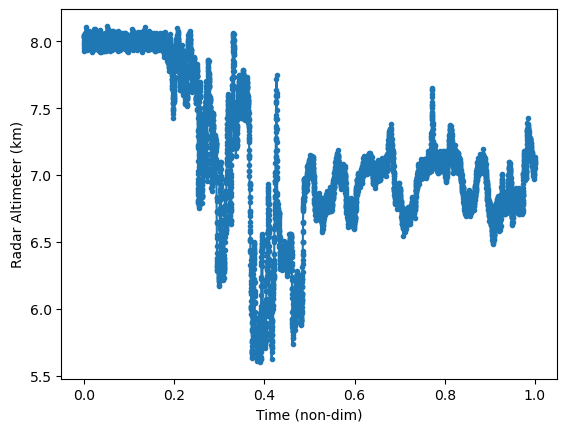

In [3]:
import pymc as pm
import terrain.pnw as terrain
import numpy as np 
import arviz as az
import scipy
import matplotlib.pyplot as plt
import pytensor.tensor as at


h0 =8
# velocity is non dimensionalized in units/time
v0 = 10
# time will be non-dim from 0-1
t0 = 0.0 
tf = 1.0
# initial position
x0 = -130.0
#
# rvs
tau = 1000
alt_error = scipy.stats.norm( loc=0, scale=1/np.sqrt(tau) ) 
# generate simulated measurements
t_true=  np.arange( start=t0 ,stop=tf , step=0.0001)
t_measured = t_true #+ time_error.rvs( size= len(t_true) ) 
x_measured = x0 + v0 * t_measured
#s = sim.Map_1D( "1dim.csv")
a_true =  h0 - terrain.pnw_1d.sample( x_measured )
a_measured = a_true + alt_error.rvs( size=len(a_true))

plt.figure(1)
plt.plot( t_measured , a_measured , marker="." )
plt.xlabel("Time (non-dim)")
plt.ylabel("Radar Altimeter (km)")

In [4]:
def altimeter( H0: at.TensorVariable, T: at.TensorVariable, Tau: at.TensorVariable, size: at.TensorVariable ) -> at.TensorVariable:
    M = H0-T
    return pm.Normal.dist( M , tau=Tau, size=size)
with pm.Model() as uPriors:
    # associate data with model (this makes prediction easier)
    H_data = pm.Data("Hm", a_measured, mutable=False)
    T_data = pm.Data("Tm", t_measured, mutable=True )
    # priors - uniform giving equal weight to all possible locations and velocities in range
    X0 = pm.Uniform("x0", lower=-135, upper=-125)  #pm.Uniform("x0", lower=10, upper=40) # pm.Normal( "X0" , mu=35, sigma=3)
    H0 = pm.Uniform("h0", lower=7.8, upper=8.2) # pm.Normal( "H0", mu=40, sigma=5 )
    V0 = pm.Uniform("v0", lower=8, upper=12)
    Tau = pm.Gamma( "Tau", alpha=100, beta=1)
    # X position through the terrain
    X = X0 + (V0 * T_data)
    Xd = pm.Deterministic( "X" , X  )
    T = terrain.terrain_alt_1d( X )
    #
    A = pm.CustomDist( "Alt" ,  H0 ,T,Tau, dist=altimeter , observed=H_data)
    #
    # start sampling
    trace = pm.sample(20000)


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Slice: [x0]
>>Slice: [v0]
>NUTS: [h0, Tau]


Sampling 4 chains for 1_000 tune and 20_000 draw iterations (4_000 + 80_000 draws total) took 51 seconds.
c:\Users\Purdu\anaconda3\Lib\site-packages\arviz\utils.py:185: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


In [5]:
az.summary( trace, var_names=["x0","v0","h0","Tau"] )

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x0,-130.000,0.000,-130.000,-130.000,0.000,0.000,6380.0,12664.0,1.0
v0,10.000,0.000,10.000,10.000,0.000,0.000,6425.0,12921.0,1.0
h0,8.001,0.000,8.000,8.001,0.000,0.000,85116.0,60387.0,1.0
Tau,851.252,11.895,828.399,873.193,0.041,0.029,85869.0,59533.0,1.0


c:\Users\Purdu\anaconda3\Lib\site-packages\arviz\utils.py:185: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([<Axes: title={'center': 'x0'}>, <Axes: title={'center': 'v0'}>,
       <Axes: title={'center': 'h0'}>, <Axes: title={'center': 'Tau'}>],
      dtype=object)

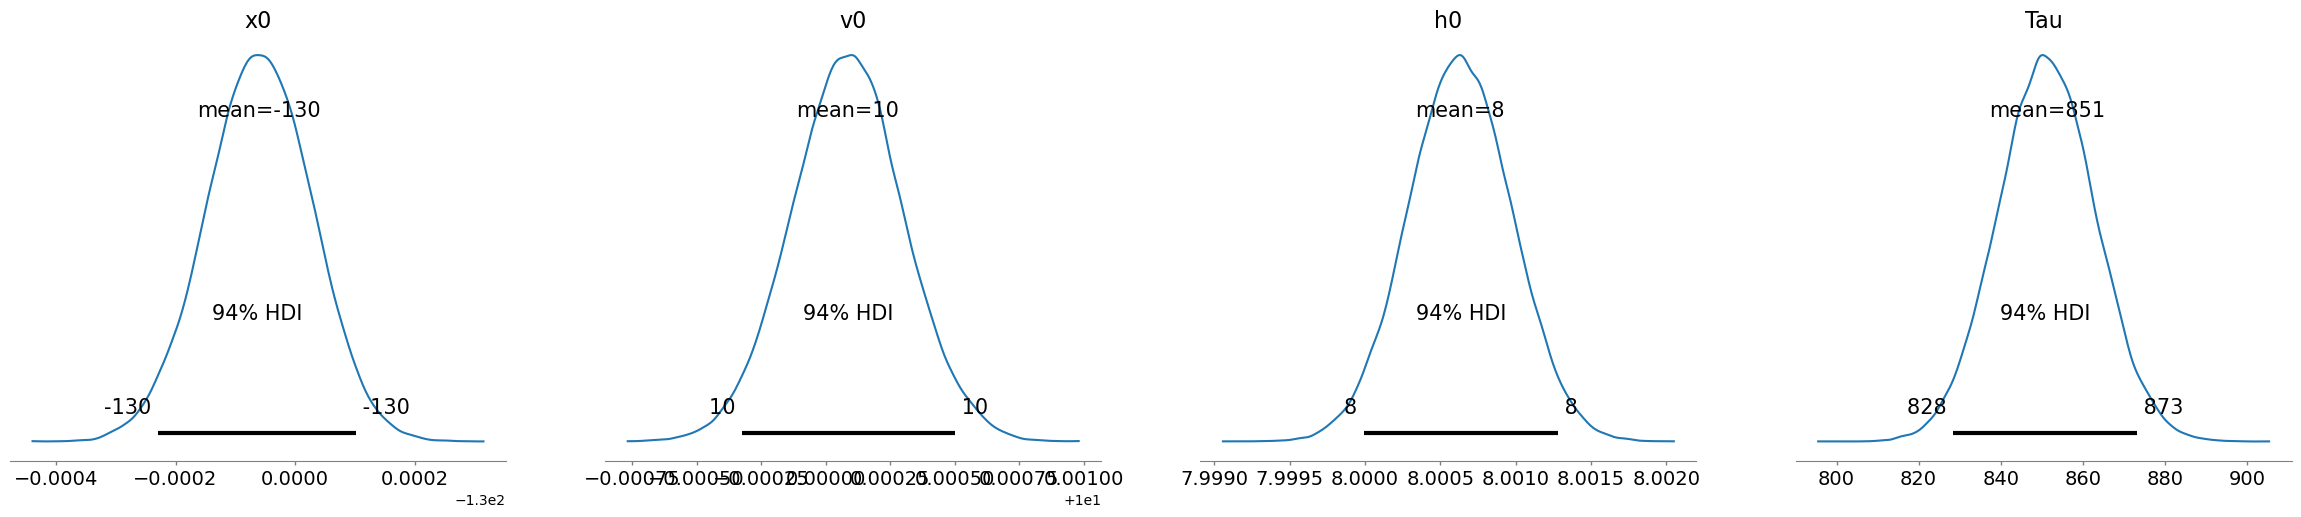

In [6]:
az.plot_posterior( trace, var_names=["x0","v0","h0","Tau"] )

c:\Users\Purdu\anaconda3\Lib\site-packages\arviz\plots\hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


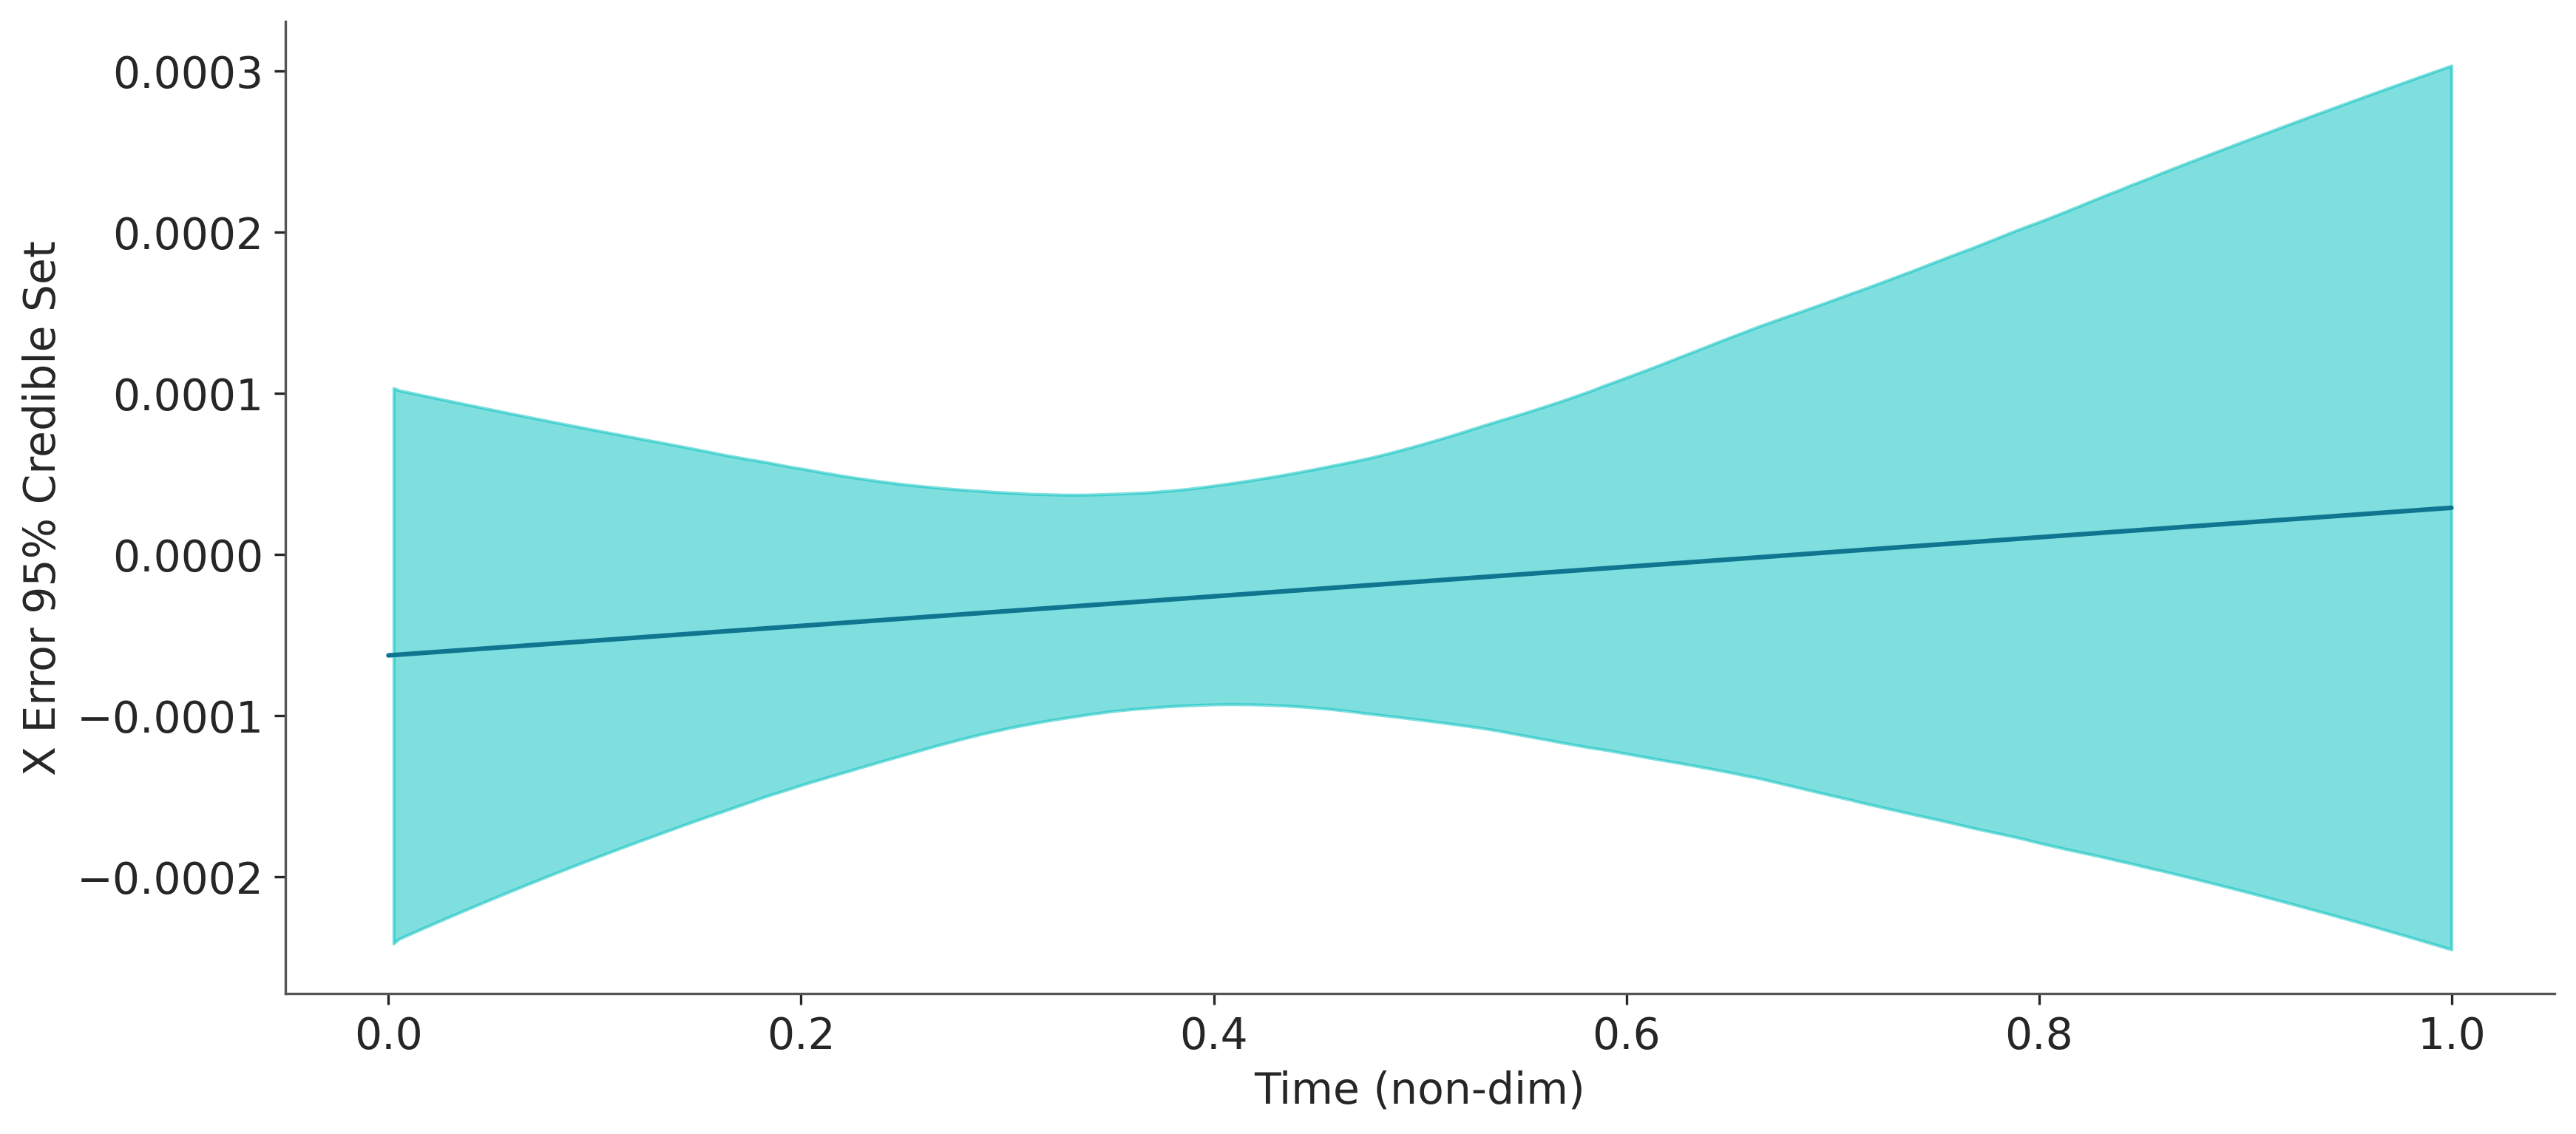

In [7]:
import seaborn as sb
import pandas as pd

xd = trace["posterior"]["X"][0,:,:]
mx =  np.mean( xd , axis=0) 

az.style.use("arviz-doc")
x = az.plot_hdi(t_measured,  xd - x_measured , hdi_prob=.95)
x.plot( t_measured , mx - x_measured )
plt.xlabel("Time (non-dim)")
plt.ylabel("X Error 95% Credible Set")
plt.show()